In [ ]:
import torch
torch.rand(1).to('cuda') #initialize cuda context (might take a while) # CHANGE TO CUDA

from net import CifarNet
import torch
from typing import List, Dict, Tuple

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=False, batch_size=32)

In [ ]:
import copy

net = CifarNet()
state_dict = torch.load('state_dict__cifarnet.pt')
net.load_state_dict(state_dict)

from utils import net_acc, size_on_disk

print(f"CifarNet Accuracy: {net_acc(CifarNet, state_dict, testloader, batches=128, device='cuda')}%")

CifarNet Accuracy: 85.3%


In [ ]:
import numpy as np
import torch.nn.utils.prune as prune 

def random_unstructured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    #set values in conv filters to zero according to the prune ratio
    for key, tensor in state_dict.items():
        if 'conv' in key and 'weight' in key:
            #print(tensor.shape)
            flat = tensor.flatten()
            total = flat.numel()
            ratio_calculated = int(total * prune_ratio)

            mask = torch.ones_like(flat)
            zero_indexes = torch.randperm(total)[:ratio_calculated]
            mask[zero_indexes] = 0
            mask = mask.view(tensor.shape)

            state_dict[key] = tensor * mask
    return state_dict

def l1_unstructured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    #set values in conv filters to zero according to the prune ratio
    for key, tensor in state_dict.items():
        if 'conv' in key and 'weight' in key:
            #print(tensor.shape)
            weights_np = tensor.numpy() # if on GPU then .cpu() before numpy
            flat = weights_np.flatten()
            threshold = np.percentile(np.abs(flat), prune_ratio * 100)
            
            flat[np.abs(flat) < threshold] = 0
            flat = torch.from_numpy(flat)
            pruned = flat.view(tensor.shape)

            state_dict[key] = pruned
            #print(threshold)
            #toberemoved = tensor[tensor < threshold]
            #print(toberemoved)
    return state_dict

100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


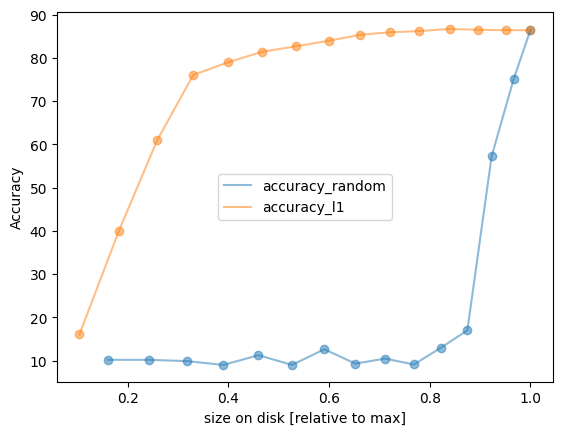

In [ ]:
import tqdm
from utils import plot
ratios = [i/15.0 for i in  range(15)]
sd = torch.load('state_dict__cifarnet.pt')
accs_random, size_random = [], []
for ratio in tqdm.tqdm(ratios):
    
    # Apply random unstructured pruning 
    sd_pruned = random_unstructured_pruning(sd, ratio)
    
    # Evaluate accuracy
    accs_random.append(net_acc(CifarNet, sd_pruned, testloader, batches=32, device='cuda'))
    
    # Evaluate size of network on disk (gzip)
    size_random.append(size_on_disk(sd_pruned)[0])
    
accs_l1, size_l1 = [], []
for ratio in tqdm.tqdm(ratios):
    # Apply L1 unstructued pruning
    sd_pruned = l1_unstructured_pruning(sd, ratio)
    accs_l1.append(net_acc(CifarNet, sd_pruned, testloader, batches=32, device='cuda'))
    size_l1.append(size_on_disk(sd_pruned)[0])

    
plot([(size_random, accs_random, 'accuracy_random'),
      (size_l1, accs_l1, 'accuracy_l1')],
      xlabel='size on disk [relative to max]', save_path='size_on_disk.png')